# Simple Claude-Generated DDPM Notebook

Below is a simple Diffusion Architecture trained on a 2D data distribution which visualizes two crescent moons! The example is simple enough that you can play around with and modify the model as you like to see how it effects the output!

# Imports

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons, make_circles

# Toy Moons Data Distribution

In [40]:
def generate_2d_data(num_samples=1000, data_type='moons'):
    """Generate 2D datasets"""
    if data_type == 'moons':
        X, _ = make_moons(n_samples=num_samples, noise=0.1)
    elif data_type == 'circles':
        X, _ = make_circles(n_samples=num_samples, noise=0.1, factor=0.5)
    elif data_type == 'gaussian_mixture':
        centers = [(0, 0), (2, 2), (-2, 2), (2, -2)]
        n_per_cluster = num_samples // len(centers)
        X = np.vstack([
            np.random.normal(loc=center, scale=0.3, size=(n_per_cluster, 2))
            for center in centers
        ])
    else:
        raise ValueError(f"Unknown data type: {data_type}")

    return torch.FloatTensor(X)

real_samples = generate_2d_data(1000, 'moons')

# MLP Denoising Diffusion Model

In [41]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=3):  # input_dim = 2D data point + time step
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 2)  # Output is 2D noise prediction
        )

    def forward(self, x, t):
        x = torch.cat([x, t], dim=1)
        return self.net(x)

class ToyDiffusion2D:
    def __init__(self, num_timesteps=100):
        self.num_timesteps = num_timesteps
        # Beta schedule
        self.betas = torch.linspace(1e-4, 0.02, num_timesteps)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

        self.model = SimpleMLP()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def forward_diffusion(self, x_0, t):
        """Add noise to the 2D data"""
        alpha_bar = self.alpha_bars[t]
        alpha_bar = alpha_bar.reshape(-1, 1)

        eps = torch.randn_like(x_0)  # 2D noise
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * eps
        return x_t, eps

    def train_step(self, x_0, t):
        """Single training step"""
        x_t, eps = self.forward_diffusion(x_0, t)

        # Time embedding
        t_embed = t.reshape(-1, 1).float() / self.num_timesteps

        # Predict noise
        eps_pred = self.model(x_t, t_embed)
        loss = F.mse_loss(eps_pred, eps)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    @torch.no_grad()
    def sample(self, num_samples=100):
        """Generate 2D samples using the reverse diffusion process"""
        x = torch.randn(num_samples, 2)  # Start from 2D noise

        for t in range(self.num_timesteps - 1, -1, -1):
            t_tensor = torch.ones(num_samples, dtype=torch.long) * t
            t_embed = t_tensor.reshape(-1, 1).float() / self.num_timesteps

            eps_theta = self.model(x, t_embed)

            alpha = self.alphas[t]
            alpha_bar = self.alpha_bars[t]
            beta = self.betas[t]

            noise = torch.randn_like(x) if t > 0 else 0

            x = (1 / torch.sqrt(alpha)) * (
                x - (beta / torch.sqrt(1 - alpha_bar)) * eps_theta
            ) + torch.sqrt(beta) * noise

        return x

# Train

In [54]:
def train_diffusion(num_epochs=2000, data_type='moons', batch_size=128):
    diffusion = ToyDiffusion2D()

    for epoch in range(num_epochs):
        x_0 = generate_2d_data(batch_size, data_type)
        t = torch.randint(0, diffusion.num_timesteps, (batch_size,))

        loss = diffusion.train_step(x_0, t)

        if (epoch + 1) % 200 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

    return diffusion

diffusion = train_diffusion(num_epochs=5000, data_type='moons')

Epoch 200, Loss: 0.5581
Epoch 400, Loss: 0.5138
Epoch 600, Loss: 0.5564
Epoch 800, Loss: 0.5181
Epoch 1000, Loss: 0.5857
Epoch 1200, Loss: 0.5723
Epoch 1400, Loss: 0.5003
Epoch 1600, Loss: 0.5748
Epoch 1800, Loss: 0.6279
Epoch 2000, Loss: 0.5531
Epoch 2200, Loss: 0.5781
Epoch 2400, Loss: 0.6335
Epoch 2600, Loss: 0.4421
Epoch 2800, Loss: 0.6042
Epoch 3000, Loss: 0.5928
Epoch 3200, Loss: 0.5447
Epoch 3400, Loss: 0.5515
Epoch 3600, Loss: 0.5752
Epoch 3800, Loss: 0.5521
Epoch 4000, Loss: 0.5312
Epoch 4200, Loss: 0.4303
Epoch 4400, Loss: 0.4214
Epoch 4600, Loss: 0.4130
Epoch 4800, Loss: 0.5698
Epoch 5000, Loss: 0.4754


# Visualize

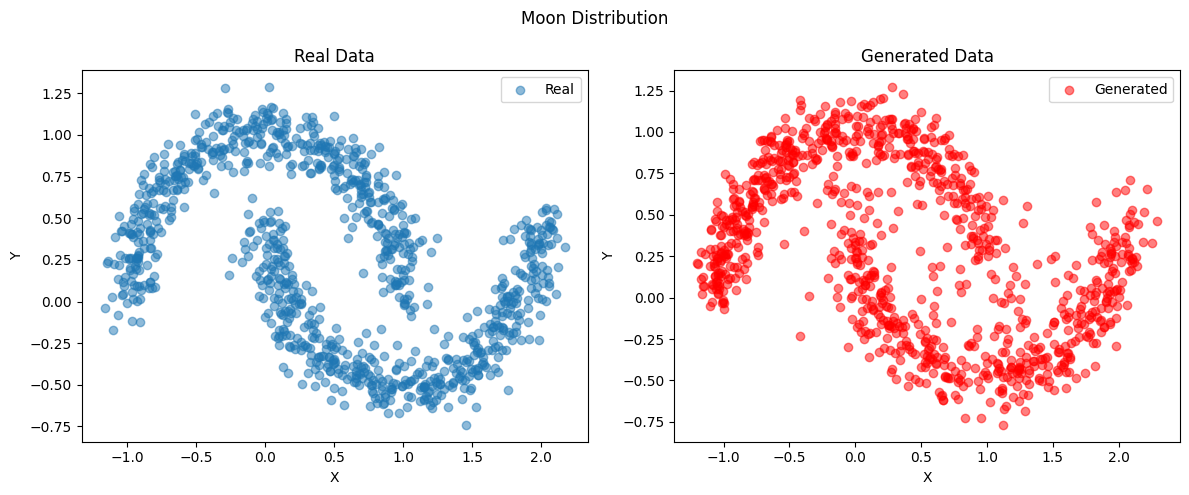

In [55]:

def visualize_samples(real_samples, generated_samples, title="Data Distribution"):
    plt.figure(figsize=(12, 5))

    # Plot real data
    plt.subplot(121)
    plt.scatter(real_samples[:, 0], real_samples[:, 1], alpha=0.5, label='Real')
    plt.title("Real Data")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()

    # Plot generated data
    plt.subplot(122)
    plt.scatter(generated_samples[:, 0], generated_samples[:, 1],
                alpha=0.5, color='red', label='Generated')
    plt.title("Generated Data")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

generated_samples = diffusion.sample(1000)
visualize_samples(real_samples, generated_samples, "Moon Distribution")